In [27]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 160

import tensorflow.keras as keras
from tensorflow.keras.layers import Input, LSTM, Dense
from IPython.display import clear_output

from slider import Preprocessing, Settings, Visualization
from slider import ImageAnalysis, ParticleAnalysis, NetworkAnalysis, CommunityAnalysis, Analyze

In [4]:
photoelasticImageData, whiteLightImageData, forceData, trackingData, metadata = Preprocessing.loadSliderData(loadCachedData=True)
peakTimes = Preprocessing.identifyPeaks(forceData, returnTimes=True)
timeArr = forceData[0][:,1]

Reading tracking data from cache: Cache/Tracking/shape0_01.pickle


In [17]:
sL = 10

metrics = [ImageAnalysis.varianceBrightness, ImageAnalysis.averageBrightness,
           CommunityAnalysis.averageCommunitySize, CommunityAnalysis.numberOfCommunities]

metricList = np.array(Analyze.analyze(photoelasticImageData, trackingData, metrics, metadata)[0])

Reading analysis result from cache: Cache/Analysis/shape_01_numberOfCommunities_21997.pickle
Reading analysis result from cache: Cache/Analysis/shape_01_averageCommunitySize_21997.pickle
Reading analysis result from cache: Cache/Analysis/shape_01_averageBrightness_21997.pickle
Reading analysis result from cache: Cache/Analysis/shape_01_varianceBrightness_21997.pickle


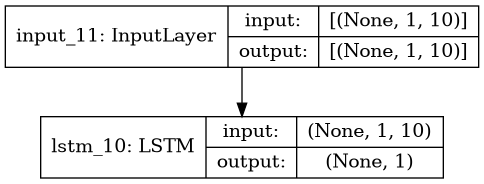

In [76]:
model = keras.Sequential()

model.add(Input(shape=(1, sL)))
model.add(LSTM(1, activation='sigmoid'))
#model.add(Dense(40, activation='relu'))
#model.add(Dense(40, activation='tanh'))
#model.add(Dense(1, activation='elu'))

model.compile(optimizer='adam', loss='mse')
keras.utils.plot_model(model, show_shapes=True)

In [92]:
# Train on sequences of variables to predict the next value of one of them
predictionMetricIndex = 1 # Predict the average brightness
batchSize = 100

inputMetrics = []
outputMetric = []

i = 0
while i < len(timeArr)-batchSize:
    inputMetrics.append([[metricList[predictionMetricIndex,j:j+sL]] for j in range(i,i+batchSize)])
    outputMetric.append([metricList[predictionMetricIndex,j+sL+1] for j in range(i,i+batchSize)])
    i += batchSize
    
inputMetrics = np.array(inputMetrics)
outputMetric = np.array(outputMetric)
print(np.shape(inputMetrics))
print(np.shape(outputMetric))

error = []
#for i in np.linspace(sL, len(timeArr), int(len(timeArr)/batchSize)-1, dtype=int):
for i in range(len(inputMetrics)-2):
    #inputMetrics = np.array([metricList[:,j:j+sL] for j in range(i,i+batchSize)])
    #outputMetric = np.array([metricList[predictionMetricIndex][i+sL:i+sL+1] for j in range(i,i+batchSize)])
    print(np.shape(inputMetrics[i]))
    print(np.shape(outputMetric[i]))
    
    error.append(model.train_on_batch(inputMetrics[i], outputMetric[i]))
    
    clear_output(wait=True)
    plt.plot(error)
    plt.show()

(219, 100, 1, 10)
(219, 100)
(100, 1, 10)
(100,)


TypeError: 'NoneType' object is not callable

In [69]:
accuracy = model.evaluate(np.array(inputMetrics[-2]), np.array(outputMetric[-2]))[1]

16/16 [==============================] - 0s 750us/step - loss: 1.7486


TypeError: 'float' object is not subscriptable